TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal

In [5]:
import math

In [6]:
import sys, os

In [7]:
import pickle

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
'''def calc_U(shape, h, h_max): #dim_i, dim_j):
    dim_i, dim_j = calc_dim(shape, h, h_max)
    U = []
    for i in range(dim_i):
        for j in range(dim_j):
            U += [(i, j)]
    return U'''
from waveimage import calc_U

In [10]:
def mnist_reshape_32_buf(x):
    assert x.shape == (28 * 28,)
    image = x.reshape(28,28)
    image = np.append(np.zeros((2,28)), image, axis = 0)
    image = np.append(image, np.zeros((2,28)), axis = 0)
    image = np.append(np.zeros((32,2)), image, axis = 1)
    image = np.append(image, np.zeros((32,2)), axis = 1)
    return image


## Creation de la base d'apprentissage

In [11]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

# Construction du réseau

In [12]:
class Obj:
    pass

In [13]:
params = Obj()
params.batch_size = 100

In [14]:
batch = mnist.train.next_batch(params.batch_size)
wave_tensor = wave_tensor_data(batch[0])

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [15]:
DEPTH_WAV = 3

DIM_5 = 16
WIDTH = 2

DEPTH_4 = 32
DIM_4 = DIM_5 / WIDTH # 8

DEPTH_3 = 64
DIM_3 = DIM_4 / WIDTH # 4

DEPTH_2 = 128
DIM_2 = DIM_3 / WIDTH # 2

DEPTH_1 = 256
DIM_1 = DIM_2 / WIDTH # 1

DIM_HIDDEN = 512

NB_LABEL = 10

STD = 1.

FLAG_POOL = False

In [16]:
nb_param_54 = (DEPTH_WAV * WIDTH * WIDTH) * DEPTH_4
nb_param_43 = (DEPTH_4 * WIDTH * WIDTH) * DEPTH_3
nb_param_32 = (DEPTH_3 * WIDTH * WIDTH) * DEPTH_2
nb_param_21 = (DEPTH_2 * WIDTH * WIDTH) * DEPTH_1
nb_param_1h = (DEPTH_1 + DEPTH_WAV + 1) * DIM_HIDDEN
nb_param_hr = DIM_HIDDEN * NB_LABEL
print (nb_param_54, nb_param_43, nb_param_32, nb_param_21, nb_param_1h, nb_param_hr)

(384, 8192, 32768, 131072, 133120, 5120)


In [17]:
DEPTH_1 + DEPTH_2 + DEPTH_3 + DEPTH_4 + DEPTH_WAV + 1

484

In [18]:
def weight_variable(shape, stddev = 0.1, name = "dummy", reuse = False):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    #initial = tf.zeros(shape)
    if reuse:
        return tf.get_variable(name)
    else:
        initial = tf.random_normal(shape, stddev = stddev)
        return tf.Variable(initial, name = name)

### placeholders

In [19]:
x_5 = tf.placeholder(tf.float32, shape=[None, DIM_5, DIM_5, DEPTH_WAV])
x_4 = tf.placeholder(tf.float32, shape=[None, DIM_4, DIM_4, DEPTH_WAV])
x_3 = tf.placeholder(tf.float32, shape=[None, DIM_3, DIM_3, DEPTH_WAV])
x_2 = tf.placeholder(tf.float32, shape=[None, DIM_2, DIM_2, DEPTH_WAV])
x_1 = tf.placeholder(tf.float32, shape=[None, DIM_1, DIM_1, DEPTH_WAV])
x_0 = tf.placeholder(tf.float32, shape=[None, 1, 1, 1])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
batch_phase = tf.placeholder(tf.bool, name='bn_phase')

### Layers

#### 5 --> 4

In [20]:
# Paramètres
if not FLAG_POOL :
    W_conv_54_flux1 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4], \
                                stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                                name = "W_conv_54_flux1")
    # Graph construction
    h_conv_4_flux1 = tf.nn.conv2d(x_5, W_conv_54_flux1, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_4_flux1') 
    z_conv_4_flux1 = tf.nn.relu(h_conv_4_flux1)
else:
    W_conv_54_flux1 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_WAV, DEPTH_4], \
                                stddev = STD / (WIDTH * WIDTH * 4 * DEPTH_WAV), \
                                name = "W_conv_54_flux1")
    h_conv_4_flux1 = tf.nn.conv2d(x_5, W_conv_54_flux1, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_4_flux1') 
    h_pool_4_flux1 = tf.nn.max_pool(h_conv_4_flux1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_4_flux1')
    #h_pool_4_bn_flux1 = tf.contrib.layers.batch_norm(h_pool_4_flux1, center=True, scale=True, is_training=batch_phase, scope='h_pool_4_flux1', updates_collections=None)
    z_conv_4_flux1 = tf.nn.relu(h_pool_4_flux1)

#h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_4') 
#h_conv_4_bn = tf.contrib.layers.batch_norm(h_conv_4, center=True, scale=True, is_training=batch_phase, scope='h_conv_4', updates_collections=None)
#z_conv_4 = tf.nn.relu(h_conv_4_bn)

#cat_conv_4 = tf.concat((z_conv_4, x_4), axis = 3)


#### 4 --> 3

In [21]:
# Paramètres
if not FLAG_POOL :
    W_conv_43_flux1 = weight_variable([WIDTH, WIDTH, DEPTH_4, DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_4), \
                            name = "W_conv_43_flux1")
    h_conv_3_flux1 = tf.nn.conv2d(z_conv_4_flux1, W_conv_43_flux1, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_3_flux1') 
    z_conv_3_flux1 = tf.nn.relu(h_conv_3_flux1)
    #
    W_conv_43_flux2 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                            name = "W_conv_43_flux1")
    h_conv_3_flux2 = tf.nn.conv2d(x_4, W_conv_43_flux2, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_3_flux2') 
    z_conv_3_flux2 = tf.nn.relu(h_conv_3_flux2)

else:
    W_conv_43_flux1 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_4, DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * 4 * DEPTH_4), \
                            name = "W_conv_43_flux1")
    h_conv_3_flux1 = tf.nn.conv2d(z_conv_4_flux1, W_conv_43_flux1, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_3_flux1') 
    h_pool_3_flux1 = tf.nn.max_pool(h_conv_3_flux1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_3_flux1')
    #h_pool_3_bn_flux1 = tf.contrib.layers.batch_norm(h_pool_3_flux1, center=True, scale=True, is_training=batch_phase, scope='h_pool_3_flux1', updates_collections=None)
    z_conv_3_flux1 = tf.nn.relu(h_pool_3_flux1)
    #
    W_conv_43_flux2 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_WAV, DEPTH_4],\
                            stddev = STD / (WIDTH * WIDTH * 4 * DEPTH_WAV), \
                            name = "W_conv_43_flux1")
    h_conv_3_flux2 = tf.nn.conv2d(x_4, W_conv_43_flux2, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_3_flux2') 
    h_pool_3_flux2 = tf.nn.max_pool(h_conv_3_flux2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_3_flux2')
    #h_pool_3_bn_flux2 = tf.contrib.layers.batch_norm(h_pool_3_flux2, center=True, scale=True, is_training=batch_phase, scope='h_pool_3_flux2', updates_collections=None)
    z_conv_3_flux2 = tf.nn.relu(h_pool_3_flux2)

# Graph construction
#h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_3') 
#h_conv_3_bn = tf.contrib.layers.batch_norm(h_conv_3, center=True, scale=True, is_training=batch_phase, scope='h_conv_3', updates_collections=None)
#z_conv_3 = tf.nn.relu(h_conv_3_bn)

#cat_conv_3 = tf.concat((z_conv_3, x_3), axis = 3)




#### 3 --> 2

In [22]:
# Paramètres
if not FLAG_POOL :
    W_conv_32_flux1 = weight_variable([WIDTH, WIDTH, DEPTH_3 , DEPTH_2],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_3 ), \
                            name = "W_conv_32_flux1")
    h_conv_2_flux1 = tf.nn.conv2d(z_conv_3_flux1, W_conv_32_flux1, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_2_flux1') 
    z_conv_2_flux1 = tf.nn.relu(h_conv_2_flux1)
    
    W_conv_32_flux2 = weight_variable([WIDTH, WIDTH, DEPTH_4 , DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_4 ), \
                            name = "W_conv_32_flux1")
    h_conv_2_flux2 = tf.nn.conv2d(z_conv_3_flux2, W_conv_32_flux2, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_2_flux2') 
    z_conv_2_flux2 = tf.nn.relu(h_conv_2_flux2)
    
    W_conv_32_flux3 = weight_variable([WIDTH, WIDTH, DEPTH_WAV , DEPTH_4],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV ), \
                            name = "W_conv_32_flux3")
    h_conv_2_flux3 = tf.nn.conv2d(x_3, W_conv_32_flux3, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_2_flux3') 
    z_conv_2_flux3 = tf.nn.relu(h_conv_2_flux3)

else:
    W_conv_32_flux1 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_3 , DEPTH_2],\
                            stddev = STD / (WIDTH * WIDTH * 4 * DEPTH_3 ), \
                            name = "W_conv_32_flux1")
    h_conv_2_flux1 = tf.nn.conv2d(z_conv_3_flux1, W_conv_32_flux1, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_2_flux1') 
    h_pool_2_flux1 = tf.nn.max_pool(h_conv_2_flux1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2_flux1')
    #h_pool_2_bn_flux1 = tf.contrib.layers.batch_norm(h_pool_2_flux1, center=True, scale=True, is_training=batch_phase, scope='h_pool_2_flux1', updates_collections=None)
    z_conv_2_flux1 = tf.nn.relu(h_pool_2_flux1)
    
    W_conv_32_flux2 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_4 , DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * 4 * DEPTH_4 ), \
                            name = "W_conv_32_flux1")
    h_conv_2_flux2 = tf.nn.conv2d(z_conv_3_flux2, W_conv_32_flux2, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_2_flux2') 
    h_pool_2_flux2 = tf.nn.max_pool(h_conv_2_flux2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2_flux2')
    #h_pool_2_bn_flux2 = tf.contrib.layers.batch_norm(h_pool_2_flux2, center=True, scale=True, is_training=batch_phase, scope='h_pool_2_flux2', updates_collections=None)
    z_conv_2_flux2 = tf.nn.relu(h_pool_2_flux2)
    
    W_conv_32_flux3 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_WAV , DEPTH_4],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV ), \
                            name = "W_conv_32_flux3")
    h_conv_2_flux3 = tf.nn.conv2d(x_3, W_conv_32_flux3, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_2_flux3') 
    h_pool_2_flux3 = tf.nn.max_pool(h_conv_2_flux3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2_flux3')
    #h_pool_2_bn_flux3 = tf.contrib.layers.batch_norm(h_pool_2_flux3, center=True, scale=True, is_training=batch_phase, scope='h_pool_2_flux3', updates_collections=None)
    z_conv_2_flux3 = tf.nn.relu(h_pool_2_flux3)

#h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_2') 
#h_conv_2_bn = tf.contrib.layers.batch_norm(h_conv_2, center=True, scale=True, is_training=batch_phase, scope='h_conv_2', updates_collections=None)
#z_conv_2 = tf.nn.relu(h_conv_2_bn)

#cat_conv_2 = tf.concat((z_conv_2, x_2), axis = 3)







#### 2 --> 1

In [23]:
if not FLAG_POOL :
    W_conv_21_flux1 = weight_variable([WIDTH, WIDTH, DEPTH_2, DEPTH_1],\
                                stddev = STD / (WIDTH * WIDTH * DEPTH_2), \
                                name = "W_conv_21_flux1")
    h_conv_1_flux1 = tf.nn.conv2d(z_conv_2_flux1, W_conv_21_flux1, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1_flux1') 
    z_conv_1_flux1 = tf.nn.relu(h_conv_1_flux1)

    # Graph construction
    #h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_1') 
    #h_conv_1_bn = tf.contrib.layers.batch_norm(h_conv_1, center=True, scale=True, is_training=batch_phase, scope='h_conv_1', updates_collections=None)
    #z_conv_1 = tf.nn.relu(h_conv_1_bn)

    W_conv_21_flux2 = weight_variable([WIDTH, WIDTH, DEPTH_3, DEPTH_2],\
                                stddev = STD / (WIDTH * WIDTH * DEPTH_3), \
                                name = "W_conv_21_flux2")
    h_conv_1_flux2 = tf.nn.conv2d(z_conv_2_flux2, W_conv_21_flux2, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1_flux2') 
    z_conv_1_flux2 = tf.nn.relu(h_conv_1_flux2)
    
    W_conv_21_flux3 = weight_variable([WIDTH, WIDTH, DEPTH_4, DEPTH_3],\
                                stddev = STD / (WIDTH * WIDTH * DEPTH_4), \
                                name = "W_conv_21_flux3")
    h_conv_1_flux3 = tf.nn.conv2d(z_conv_2_flux3, W_conv_21_flux3, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1_flux2') 
    z_conv_1_flux3 = tf.nn.relu(h_conv_1_flux3)
    
    W_conv_21_flux4 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4],\
                                stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                                name = "W_conv_21_flux4")
    h_conv_1_flux4 = tf.nn.conv2d(x_2, W_conv_21_flux4, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1_flux4') 
    z_conv_1_flux4 = tf.nn.relu(h_conv_1_flux4)
    
else:
    W_conv_21_flux1 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_2, DEPTH_1],\
                                stddev = STD / (WIDTH * WIDTH * 4 * DEPTH_2), \
                                name = "W_conv_21_flux1")
    h_conv_1_flux1 = tf.nn.conv2d(z_conv_2_flux1, W_conv_21_flux1, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_1_flux1') 
    h_pool_1_flux1 = tf.nn.max_pool(h_conv_1_flux1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1_flux1')
    #h_pool_1_bn_flux1 = tf.contrib.layers.batch_norm(h_pool_1_flux1, center=True, scale=True, is_training=batch_phase, scope='h_pool_1_flux1', updates_collections=None)
    z_conv_1_flux1 = tf.nn.relu(h_pool_1_flux1)
    
    W_conv_21_flux2 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_3, DEPTH_2],\
                                stddev = STD / (WIDTH * WIDTH * 4 * DEPTH_3), \
                                name = "W_conv_21_flux2")
    h_conv_1_flux2 = tf.nn.conv2d(z_conv_2_flux2, W_conv_21_flux2, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_1_flux2') 
    h_pool_1_flux2 = tf.nn.max_pool(h_conv_1_flux2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1_flux2')
    #h_pool_1_bn_flux2 = tf.contrib.layers.batch_norm(h_pool_1_flux2, center=True, scale=True, is_training=batch_phase, scope='h_pool_1_flux2', updates_collections=None)
    z_conv_1_flux2 = tf.nn.relu(h_pool_1_flux2)
    
    W_conv_21_flux3 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_4, DEPTH_3],\
                                stddev = STD / (WIDTH * WIDTH * 4 * DEPTH_4), \
                                name = "W_conv_21_flux3")
    h_conv_1_flux3 = tf.nn.conv2d(z_conv_2_flux3, W_conv_21_flux3, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_1_flux2') 
    h_pool_1_flux3 = tf.nn.max_pool(h_conv_1_flux3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1_flux3')
    #h_pool_1_bn_flux3 = tf.contrib.layers.batch_norm(h_pool_1_flux3, center=True, scale=True, is_training=batch_phase, scope='h_pool_1_flux3', updates_collections=None)
    z_conv_1_flux3 = tf.nn.relu(h_pool_1_flux3)
    
    W_conv_21_flux4 = weight_variable([WIDTH * 2, WIDTH * 2, DEPTH_WAV, DEPTH_4],\
                                stddev = STD / (WIDTH * WIDTH * 4 * DEPTH_WAV), \
                                name = "W_conv_21_flux4")
    h_conv_1_flux4 = tf.nn.conv2d(x_2, W_conv_21_flux4, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_1_flux4') 
    h_pool_1_flux4 = tf.nn.max_pool(h_conv_1_flux4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1_flux4')
    #h_pool_1_bn_flux4 = tf.contrib.layers.batch_norm(h_pool_1_flux4, center=True, scale=True, is_training=batch_phase, scope='h_pool_1_flux4', updates_collections=None)
    z_conv_1_flux4 = tf.nn.relu(h_pool_1_flux4)
##

#cat_conv_1 = tf.concat((z_conv_1_flux1, z_conv_1_flux2, z_conv_1_flux3, z_conv_1_flux4, x_1, x_0), axis = 3)
#z_flat1 = tf.reshape(cat_conv_1, [-1, DEPTH_1 + DEPTH_2 + DEPTH_3 + DEPTH_4 + DEPTH_WAV + 1])#


### simple comb

In [24]:
z_conv_1_flux5 = tf.concat((x_1, x_0), axis = 3)
W_hidden_flux5 = weight_variable([DEPTH_WAV + 1, DEPTH_4], stddev = STD / (DEPTH_WAV + 1), name = "W_hidden_flux5")
h_hidden_flux5 = tf.matmul(tf.reshape(z_conv_1_flux5, [-1, DEPTH_WAV + 1]), W_hidden_flux5)
z_hidden_flux5 = tf.nn.relu(h_hidden_flux5)

z_concat_4 = tf.concat((tf.reshape(z_conv_1_flux4, [-1, DEPTH_4]), z_hidden_flux5), axis = 1)
W_hidden_flux4 = weight_variable([DEPTH_4 + DEPTH_4, DEPTH_3], stddev = STD / (DEPTH_4 + DEPTH_4), name = "W_hidden_flux2")
h_hidden_flux4 = tf.matmul(z_concat_4, W_hidden_flux4)
z_hidden_flux4 = tf.nn.relu(h_hidden_flux4)

z_concat_3 = tf.concat((tf.reshape(z_conv_1_flux3, [-1, DEPTH_3]), z_hidden_flux4), axis = 1)
W_hidden_flux3 = weight_variable([DEPTH_3 + DEPTH_3, DEPTH_2], stddev = STD / (DEPTH_3 + DEPTH_3), name = "W_hidden_flux3")
h_hidden_flux3 = tf.matmul(z_concat_3, W_hidden_flux3)
z_hidden_flux3 = tf.nn.relu(h_hidden_flux3)

z_concat_2 = tf.concat((tf.reshape(z_conv_1_flux2, [-1, DEPTH_2]), z_hidden_flux3), axis = 1)
W_hidden_flux2 = weight_variable([DEPTH_2 + DEPTH_2, DEPTH_1], stddev = STD / (DEPTH_2 + DEPTH_2), name = "W_hidden_flux2")
h_hidden_flux2 = tf.matmul(z_concat_2, W_hidden_flux2)
z_hidden_flux2 = tf.nn.relu(h_hidden_flux2)

z_concat_1 = tf.concat((tf.reshape(z_conv_1_flux1, [-1, DEPTH_1]), z_hidden_flux2), axis = 1)
W_hidden_flux1 = weight_variable([DEPTH_1 + DEPTH_1, DIM_HIDDEN], stddev = STD / (DEPTH_1 + DEPTH_1), name = "W_hidden_flux1")
h_hidden_flux1 = tf.matmul(z_concat_1, W_hidden_flux1)
z_hidden_flux1 = tf.nn.relu(h_hidden_flux1)

#z_hidden_concat = tf.concat((z_hidden_flux1, z_hidden_flux2, z_hidden_flux3, z_hidden_flux4, z_hidden_flux5), axis = 1)
W_hidden = weight_variable([DIM_HIDDEN, DIM_HIDDEN], stddev = STD / DIM_HIDDEN, name = "W_hidden")
h_hidden = tf.matmul(z_hidden_flux1, W_hidden)
z_hidden = tf.nn.relu(h_hidden)
z_hidden_drop = tf.nn.dropout(z_hidden, keep_prob)

#### hidden FC layer

In [25]:
#W_hidden = weight_variable([DEPTH_1 + DEPTH_2 + DEPTH_3 + DEPTH_4 + DEPTH_WAV + 1, DIM_HIDDEN], stddev = STD / (DEPTH_1 + DEPTH_2 + DEPTH_3 + DEPTH_4 + DEPTH_WAV + 1), name = "W_hidden")
#h_hidden = tf.matmul(z_flat1, W_hidden)
#z_hidden = tf.nn.relu(h_hidden)
#z_hidden_drop = tf.nn.dropout(z_hidden, keep_prob)

#### readout layer

In [26]:
W_readout = weight_variable([DIM_HIDDEN, NB_LABEL], stddev = STD / DIM_HIDDEN, name = "W_readout")
y_hat_logit = tf.matmul(z_hidden_drop, W_readout)

### Loss graph¶

In [27]:
classif_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat_logit))

#l1_regularizer = tf.contrib.layers.l1_regularizer(
#   scale=0.005, scope=None
#)
#weights = tf.trainable_variables() # all vars of your graph
#regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

regularized_loss = classif_loss #+ regularization_penalty # this loss needs to be min

### Train graph¶

In [28]:
train = tf.train.AdamOptimizer(1e-5).minimize(regularized_loss)

### Evaluation graph

In [29]:
correct_prediction = tf.equal(tf.argmax(y_hat_logit, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training session

In [30]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [31]:
mem = Obj()
mem.num_epoch = []
mem.classif_eval = []


In [32]:
params.n_epochs = 200000

In [ ]:
file_name = "models/mnist-waveimage-CNN-parallel-comb-alt-500"

if not os.path.isfile(file_name + ".ckpt.index"):
    for num_epoch in range (params.n_epochs):
        if num_epoch % 10 == 0:
            mem.num_epoch += [num_epoch]
            x_test, y_test = mnist.test.next_batch(params.batch_size)
            wave_tensor = wave_tensor_data(x_test)
            classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                                    x_4: wave_tensor[4],\
                                                    x_3: wave_tensor[3],\
                                                    x_2: wave_tensor[2],\
                                                    x_1: wave_tensor[1],\
                                                    x_0: wave_tensor[0],\
                                                    y: y_test,\
                                                    keep_prob: 1,\
                                                    batch_phase:False})
            mem.classif_eval += [classif_eval]
            sys.stdout.write('\rstep %d\t classif : %.5f' \
                             % (num_epoch, \
                                classif_eval))
        if num_epoch % 1000 == 0:
            saver.save(sess,          file_name + ".ckpt")
            pickle.dump(mem,     open(file_name + "_mem.pkl", "wb"))
        batch_x, batch_y = mnist.train.next_batch(params.batch_size) 
        wave_tensor = wave_tensor_data(batch_x)
        train.run(feed_dict={x_5: wave_tensor[5],\
                              x_4: wave_tensor[4],\
                              x_3: wave_tensor[3],\
                              x_2: wave_tensor[2],\
                              x_1: wave_tensor[1],\
                              x_0: wave_tensor[0],\
                              y: batch_y,\
                              keep_prob: 0.5,\
                              batch_phase:True})
else:
    saver.restore(sess, file_name + ".ckpt")
    mem = pickle.load(open(file_name + "_mem.pkl", "rb"))
    

step 1640	 classif : 0.98000

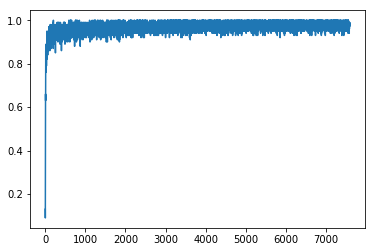

In [51]:
plt.plot(mem.classif_eval)

In [35]:
test_tensor = {}
test_tensor[5] = np.zeros((1, DIM_5, DIM_5, DEPTH_WAV))
test_tensor[4] = np.zeros((1, DIM_4, DIM_4, DEPTH_WAV))
test_tensor[3] = np.zeros((1, DIM_3, DIM_3, DEPTH_WAV))
test_tensor[2] = np.zeros((1, DIM_2, DIM_2, DEPTH_WAV))
test_tensor[1] = np.zeros((1, DIM_1, DIM_1, DEPTH_WAV))
test_tensor[0] = np.zeros((1, 1, 1, 1))

test = y_hat_logit.eval(feed_dict={ x_5: test_tensor[5],\
                                    x_4: test_tensor[4],\
                                    x_3: test_tensor[3],\
                                    x_2: test_tensor[2],\
                                    x_1: test_tensor[1],\
                                    x_0: test_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})

print test

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [36]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_data(x_test)
classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                        x_4: wave_tensor[4],\
                                        x_3: wave_tensor[3],\
                                        x_2: wave_tensor[2],\
                                        x_1: wave_tensor[1],\
                                        x_0: wave_tensor[0],\
                                        y: y_test,\
                                        keep_prob: 1,\
                                        batch_phase:False})
sys.stdout.write('\rstep %d\t classif : %.5f' \
                 % (num_epoch, \
                    classif_eval))

step 6902	 classif : 0.95520

In [41]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_data(x_test)
classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                        x_4: wave_tensor[4],\
                                        x_3: wave_tensor[3],\
                                        x_2: wave_tensor[2],\
                                        x_1: wave_tensor[1],\
                                        x_0: wave_tensor[0],\
                                        y: y_test,\
                                        keep_prob: 1,\
                                        batch_phase:False})
sys.stdout.write('\rstep %d\t classif : %.5f' \
                 % (num_epoch, \
                    classif_eval))

step 5729	 classif : 0.96990

In [46]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_data(x_test)
classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                        x_4: wave_tensor[4],\
                                        x_3: wave_tensor[3],\
                                        x_2: wave_tensor[2],\
                                        x_1: wave_tensor[1],\
                                        x_0: wave_tensor[0],\
                                        y: y_test,\
                                        keep_prob: 1,\
                                        batch_phase:False})
sys.stdout.write('\rstep %d\t classif : %.5f' \
                 % (num_epoch, \
                    classif_eval))

step 5339	 classif : 0.97120

In [49]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_data(x_test)
classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                        x_4: wave_tensor[4],\
                                        x_3: wave_tensor[3],\
                                        x_2: wave_tensor[2],\
                                        x_1: wave_tensor[1],\
                                        x_0: wave_tensor[0],\
                                        y: y_test,\
                                        keep_prob: 1,\
                                        batch_phase:False})
sys.stdout.write('\rstep %d\t classif : %.5f' \
                 % (num_epoch, \
                    classif_eval))

step 17525	 classif : 0.97750

In [52]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_data(x_test)
classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                        x_4: wave_tensor[4],\
                                        x_3: wave_tensor[3],\
                                        x_2: wave_tensor[2],\
                                        x_1: wave_tensor[1],\
                                        x_0: wave_tensor[0],\
                                        y: y_test,\
                                        keep_prob: 1,\
                                        batch_phase:False})
sys.stdout.write('\rstep %d\t classif : %.5f' \
                 % (num_epoch, \
                    classif_eval))

step 27387	 classif : 0.97760